# Initializing and Preprocessing
Load up experiment & annotations

In [20]:
import sys
sys.path.append("/tmp/pycharm_project_688/")
sys.path.append("/tmp/pycharm_project_688/src/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction, preprocess_chunks_for_null_test_with_indoor
from preprocessing._segmentation import segment_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram

In [22]:
experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
complete_experiments_indices = [3,5,11,12]
#Order: 1 - Anne; 2 - Fabi; 3 - Julian; 4 - Marvin; 5 - Ariane; 6 - Julius-2; 7 - Cilly; 8 - Ana; 9 - Julius; 10 - Antonia; 11 - Wiktoria; 12 - Ana-2;
#['../../data/phyphox/full recordings/Anne', '../../data/phyphox/full recordings/Fabi', '../../data/phyphox/full recordings/Julian', '../../data/phyphox/full recordings/Marvin', '../../data/phyphox/full recordings/Ariane', '../../data/phyphox/full recordings/Julius-2', '../../data/phyphox/full recordings/Cilly', '../../data/phyphox/full recordings/Ana', '../../data/phyphox/full recordings/Julius', '../../data/phyphox/full recordings/Antonia', '../../data/phyphox/full recordings/Wiktoria', '../../data/phyphox/full recordings/Ana-2']
experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
sample_rate = 100
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

print(experiment_dirs)

['../../data/phyphox/full recordings/Julian', '../../data/phyphox/full recordings/Ariane', '../../data/phyphox/full recordings/Wiktoria', '../../data/phyphox/full recordings/Ana-2']


In [23]:
experiment_dirs

['../../data/phyphox/full recordings/Julian',
 '../../data/phyphox/full recordings/Ariane',
 '../../data/phyphox/full recordings/Wiktoria',
 '../../data/phyphox/full recordings/Ana-2']

Preprocess data

No handles with labels found to put in legend.


Mean 14.07 +/- 16.72


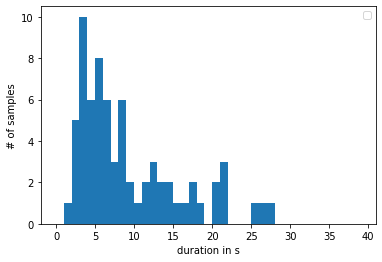

In [24]:
plot_duration_histogram(chunks["right"])

Mean 25.74 +/- 90.19


No handles with labels found to put in legend.


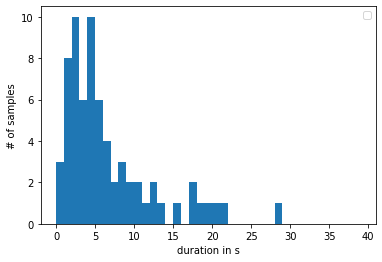

In [25]:
plot_duration_histogram(null_chunks["right"])

In [26]:
# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data

use_indoor = True

if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
else:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

labels = y.loc[:, "label"].squeeze()

### Segmentation

In [27]:
window_size = 50

# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


## Binary Classification: OCD activities vs null class samples
### Feature extraction for OCD activities vs non-OCD activities

In [28]:

X_null_class_classification = extract_timeseries_features(null_classification_df, True)

Feature Extraction:  20%|██        | 6/30 [01:40<06:43, 16.82s/it]Process ForkPoolWorker-13:

Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-16:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 

KeyboardInterrupt: 

### Feature selection

In [ ]:
impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

In [ ]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [ ]:
labels_null_classification.values

### Train models and score results

In [ ]:
print("Binary classification")
classify_all(X_null_classification, labels_null_classification, binary=True)

In [ ]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

In [ ]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_null_classification_selected.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- re label the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [29]:
# make sure we already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0

labels_ocd_multiclass = labels.reset_index(drop=True)
_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [30]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [31]:
labels_multi_class_classification

(0, 0)      pulling door
(0, 1)      pulling door
(0, 2)      pulling door
(0, 3)      pulling door
(0, 4)      pulling door
                ...     
(154, 0)      null class
(154, 1)      null class
(154, 2)      null class
(154, 3)      null class
(154, 4)      null class
Length: 3021, dtype: object

### Feature extraction for OCD activities vs non-OCD activities

In [33]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, True)

Feature Extraction: 100%|██████████| 30/30 [06:39<00:00, 13.31s/it]


In [34]:
X_multi_class_classification.head()

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,rssi__symmetry_looking__r_0.9500000000000001,rssi__time_reversal_asymmetry_statistic__lag_1,rssi__time_reversal_asymmetry_statistic__lag_2,rssi__time_reversal_asymmetry_statistic__lag_3,rssi__value_count__value_-1,rssi__value_count__value_0,rssi__value_count__value_1,rssi__variance,rssi__variance_larger_than_standard_deviation,rssi__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",746.197309,2.232656,0.085901,-0.014933,0.164751,-3.350673,-3.653047,-3.994688,0.051163,NaN,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,-0.000000e+00
"(0, 1)",823.336534,2.586590,-0.017211,-0.006552,0.114851,-4.093987,-4.177820,-4.400392,0.012735,NaN,...,1.0,1337.329102,2790.947690,4376.713423,0.0,0.0,0.0,5.496225e+00,1.0,-4.059924e-02
"(0, 2)",646.312914,2.002459,-0.202802,-0.222572,0.259081,-3.523697,-3.713727,-3.832078,0.013922,NaN,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,-0.000000e+00
"(0, 3)",653.397221,1.433035,-0.136040,-0.205304,0.205137,-3.464085,-3.532202,-3.600342,0.002569,NaN,...,1.0,21.551517,44.977078,70.532236,0.0,0.0,0.0,1.691667e-03,0.0,-7.383958e-04
"(0, 4)",700.228738,0.931295,-0.064230,0.023502,0.165236,-3.684293,-3.715686,-3.747577,0.000259,NaN,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,5.048710e-29,0.0,-1.276424e-16


### Feature selection for multi class OCD activities incl null

In [35]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)


/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:173: RuntimeWarning: The columns ['acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"'
 ... 'rssi__friedrich_coefficients__coeff_2__m_3__r_30'
 'rssi__friedrich_coefficients__coeff_3__m_3__r_30'
 'rssi__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [36]:
scaler = StandardScaler()
X_multi_class_classification = scaler.fit_transform(X_multi_class_classification_selected)

In [45]:
len(labels_multi_class_classification.unique())

18

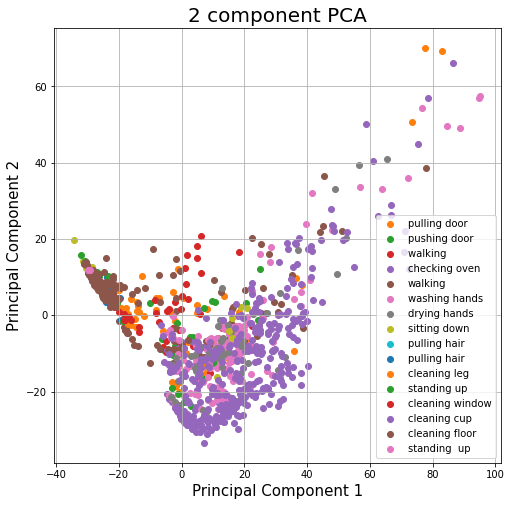

In [51]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification, labels_multi_class_classification, labels_multi_class_classification.unique()[0:16], ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

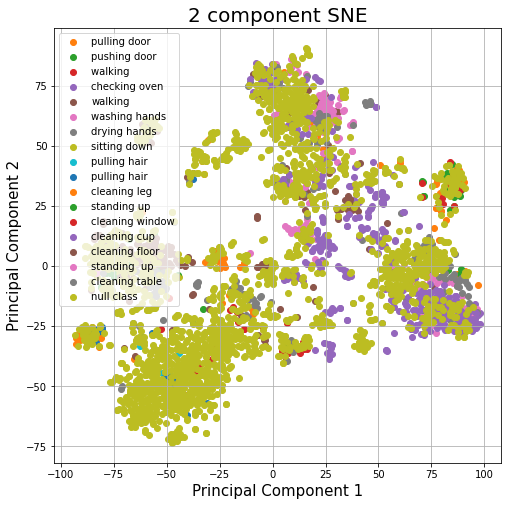

In [50]:
sne_2d(X_multi_class_classification, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

### Train models and score results

In [40]:
print("Multi class classification with null class")
classify_all(X_multi_class_classification, labels_multi_class_classification)


Multi class classification with null class


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
Process ForkPoolWorker-37:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-38:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/

KeyboardInterrupt: 